In [1]:
import sys
sys.path.append('../modules')

from operators import *
from preprocessing import *
from eof import *
from gridding import *
from mapper import *
from scipy.stats import linregress

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature
import seaborn as sns
sns.set_palette("RdGy")

import pandas as pd

%load_ext autoreload
%autoreload 2

## Snowload
---
Load data and interpolate the design value field

Text(0.5, 1.0, 'KDE Distribution of snw Values')

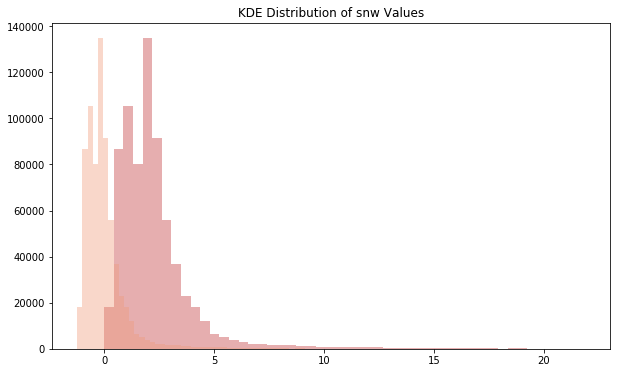

In [2]:
PATH = '/storage/data/projects/nrc/CanRCM4_large_ensemble/design_values/snw/snw_CanRCM4-LE_ens35_1951-2016_max_rl50_load.nc'
mask_path = '/home/nannau/Desktop/climpyrical/data/mask.nc'
dv = 'snw'

interp_dict = get_interpolation(mask_path, PATH, dv)
master_idx = interp_dict['idx']
north_master_idx = interp_dict['irlat_ens'] > -10.

midx = np.logical_and(north_master_idx, master_idx)

iens = (interp_dict['iens'][:, midx]).T
oldiens = iens.copy()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)
iens = scaler.fit_transform(iens)

plt.figure(figsize=(10, 6))
sns.distplot(oldiens[..., 0], kde = False, kde_kws = {'shade': True,'linewidth': 3}, label='non-anomaly')
sns.distplot(iens[..., 0], kde = False, kde_kws = {'shade': True,'linewidth': 3}, label='anomaly')
plt.title('KDE Distribution of {} Values'.format(dv))

Plot distribution.

Perform singular value decomposition

In [3]:
u, s, vT = np.linalg.svd(iens.T, full_matrices=False)
uold, sold, vTold = np.linalg.svd(oldiens.T, full_matrices=False)
del u
del uold
vT.shape

(35, 700810)

Calculate explained variance and plot

Text(0, 0.5, 'Cumulatic Explained Variance Ratio')

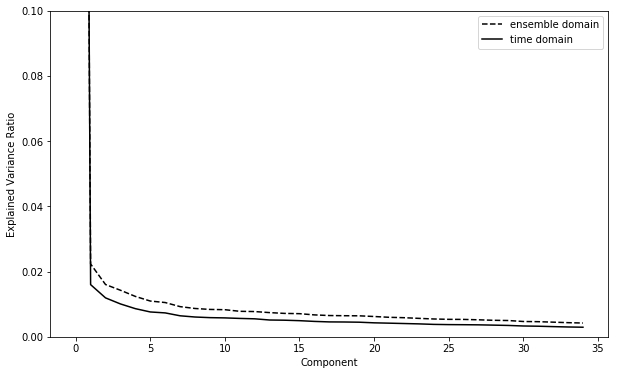

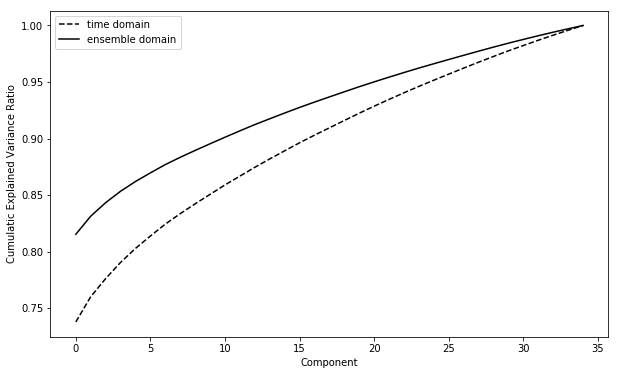

In [4]:
explained_variance_ratio = [s[i]/np.sum(s) for i in range(s.shape[0])]
cumulative_variance = np.cumsum(explained_variance_ratio)

oldexplained_variance_ratio = [sold[i]/np.sum(sold) for i in range(sold.shape[0])]
oldcumulative_variance = np.cumsum(oldexplained_variance_ratio)

component = range(s.shape[0])

plt.figure(figsize=(10, 6))
plt.plot(component, explained_variance_ratio, label='ensemble domain' , color='black', linestyle='--')
plt.plot(range(sold.shape[0]), oldexplained_variance_ratio, label='time domain', color='black')
plt.legend()
plt.ylim(0, 0.10)
plt.xlabel('Component')
plt.ylabel('Explained Variance Ratio')

plt.figure(figsize=(10, 6))
plt.plot(component, cumulative_variance, label='time domain' , color='black', linestyle='--')
plt.plot(range(sold.shape[0]), oldcumulative_variance, label='ensemble domain', color='black')
plt.legend()
#plt.ylim(0, 0.10)
plt.xlabel('Component')
plt.ylabel('Cumulatic Explained Variance Ratio')

Load the quantile station data

In [5]:
df = pd.read_csv('/home/nannau/Downloads/Interim_snow_load_LRstations_delivered.csv', index_col=None)
df.head()

,id,SD_station_name,lat,lon,prov,elevation,SL50 (kPa)
0,15,CHEMAINUS,48.9350,-123.742,BC,75.0,1.954635
1,78,SAANICHTON CDA,48.6217,-123.419,BC,61.0,0.729036
2,91,SHAWNIGAN LAKE,48.6469,-123.626,BC,159.0,2.352290
3,109,VICTORIA GONZALES HTS,48.4131,-123.325,BC,69.5,0.752725
4,149,ALERT BAY,50.5833,-126.933,BC,59.4,1.420390


In [6]:
dv = 'SL50 (kPa)'

In [7]:
ndf = match_coords(df, interp_dict, dv, midx)
print("There are ", ndf.shape, "real station observations to fit.")

There are  (477, 5) real station observations to fit.


#### Create the pseudo observations and regress

In [8]:
obs_idx = generate_pseudo_obs(iens.T, 0.0003)
print("Taking", obs_idx.shape[0], "pseudo observations")

Taking 210 pseudo observations


In [9]:
print(vT.shape)
obs = iens.T[0, obs_idx]
eofs = vT[:, obs_idx]
eofsold = vTold[:, obs_idx]

print("Check that the pseudo observations and the EOFs contain the same number of grids:",
      '\nEOF shape: ', eofs.shape, '\n'
      'Matched Obs shape: ', obs.shape)

(35, 700810)
Check that the pseudo observations and the EOFs contain the same number of grids: 
EOF shape:  (35, 210) 
Matched Obs shape:  (210,)


Fit the EOFs tot he pseudo observations and predict their values

In [10]:
model = fit_eof(eofs.T, obs.flatten())
predictions = predict_dv(model, eofs.T)

slope 0.9999999999999997 r2_val 0.9999999999999999


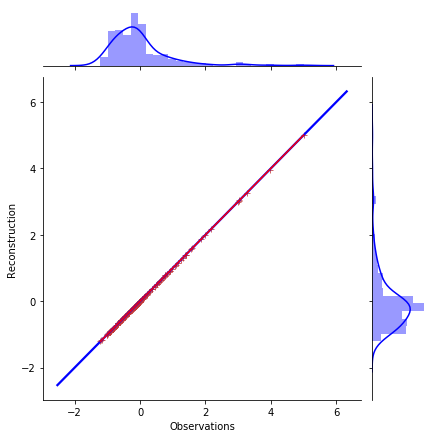

In [11]:
sns.jointplot(obs.T, predictions.T, kind='reg', color='blue',  marker='+',scatter_kws={"s": 0.01})
sns.scatterplot(obs.T, predictions.T, marker='+')
sns.lineplot(obs.T, obs.T, color='r', dashes=True)
plt.xlabel('Observations')
plt.ylabel('Reconstruction')

slope, intercept, r_value, p_value, std_err = linregress(obs.T, predictions.T)
print("slope", slope, "r2_val", r_value)

#### Use the real observations and regress

In [12]:
robs_idx = ndf['matched_idx']
robs = ((ndf[dv].values) - ndf[dv].mean(axis=0))#/ndf[dv].std(axis=0)
vT.shape, robs_idx.shape
reofs = vT[:, robs_idx].T
reofs.shape, robs.shape, #obs.shape

((477, 35), (477,))

Text(0, 0.5, 'Slope/R$^2$ Score')

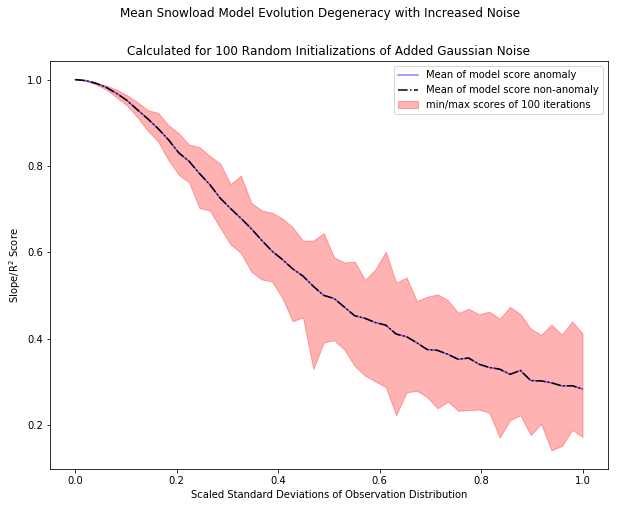

In [13]:
ys = []
x = eofs.T

ys1 = []
x1 = eofsold.T
for i in range(0, 100):
    yslopes = []
    yslopes1 = []
    for sd in np.linspace(0, np.std(robs)):
        y = obs.flatten() + np.random.normal(0., sd, obs.flatten().shape[0])
        model = fit_eof(x, y)
        model1 = fit_eof(x1, y)

        predictions = predict_dv(model, x)
        predictions1 = predict_dv(model1, x1)
        slope, intercept, r_value, p_value, std_err = linregress(y, predictions)
        slope1, intercept, r_value, p_value, std_err = linregress(y, predictions1)

        yslopes.append(slope)
        yslopes1.append(slope1)
    ys.append(yslopes)
    ys1.append(yslopes1)

ys = np.array(ys)
ys1 = np.array(ys1)
fig, ax = plt.subplots(figsize=(10, 7.5))
plt.plot(np.linspace(0, np.std(robs))/np.std(robs), ys.mean(axis=0), color='blue', alpha=0.5,linestyle='-', label='Mean of model score anomaly')
plt.plot(np.linspace(0, np.std(robs))/np.std(robs), ys1.mean(axis=0), color='black',  linestyle='-.', label='Mean of model score non-anomaly')
ax.fill_between(np.linspace(0, np.std(robs))/np.std(robs), ys.min(axis=0), ys.max(axis=0), alpha = 0.3, color='red', label='min/max scores of 100 iterations')
plt.legend()
plt.suptitle('Mean Snowload Model Evolution Degeneracy with Increased Noise')
plt.title('Calculated for 100 Random Initializations of Added Gaussian Noise')
plt.xlabel('Scaled Standard Deviations of Observation Distribution')
plt.ylabel('Slope/R$^2$ Score')

Compare the distributions of the station observations and of the models

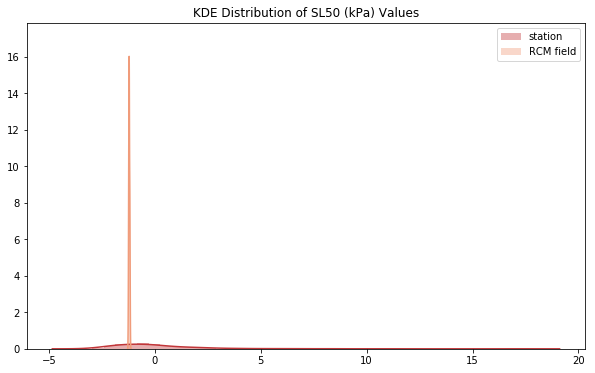

In [14]:
plt.figure(figsize=(10, 6))
plt.title('KDE Distribution of {} Values'.format(dv))
sns.distplot(robs, label='station')
sns.distplot(iens[0, ...], label='RCM field')
plt.legend()

Fit the model and predict it

In [15]:
rmodel = fit_eof(reofs, robs.flatten())
linrpredictions = predict_dv(rmodel, reofs).flatten()
linrpredictions.shape

(477,)

slope 0.3109297750999877 r2_val 0.5576107738377978
Std deviation ratio of vectors [models/]: 0.026092467051272314


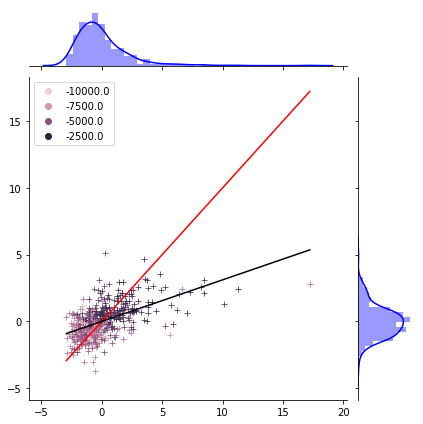

In [16]:
#fig, ax = plt.subplots(figsize=(10, 7.5))
sns.jointplot(robs, linrpredictions, ax=ax,  kind='reg', color='blue', marker='+',scatter_kws={"s": 0.01})
sns.scatterplot(robs, linrpredictions,
                marker='+',
                hue=ndf['lon']*ndf['lat'],
                )

sns.lineplot(
            robs.T, 
            robs.T,
            color='r',
            dashes=True
)


ax.set_xlabel('Observations')
ax.set_ylabel('Reconstruction')

slope, intercept, r_value, p_value, std_err = linregress(robs, linrpredictions)

sns.lineplot(robs.T,
            robs.T*slope + intercept,
            color='black',
            dashes=True
)

print("slope", slope, "r2_val", r_value)

print("Std deviation ratio of vectors [models/]:", np.mean(np.std(iens, axis=1))/np.std(robs))

In [17]:
dv_recon = interp_dict['iens'][0, ...].copy()
dv_recon[midx] = rmodel.predict(vT.T)
dv_recon[~midx] = np.nan 

In [18]:
dv_recon_sq = dv_recon.reshape(interp_dict['irlat'].shape[0], interp_dict['irlon'].shape[0])

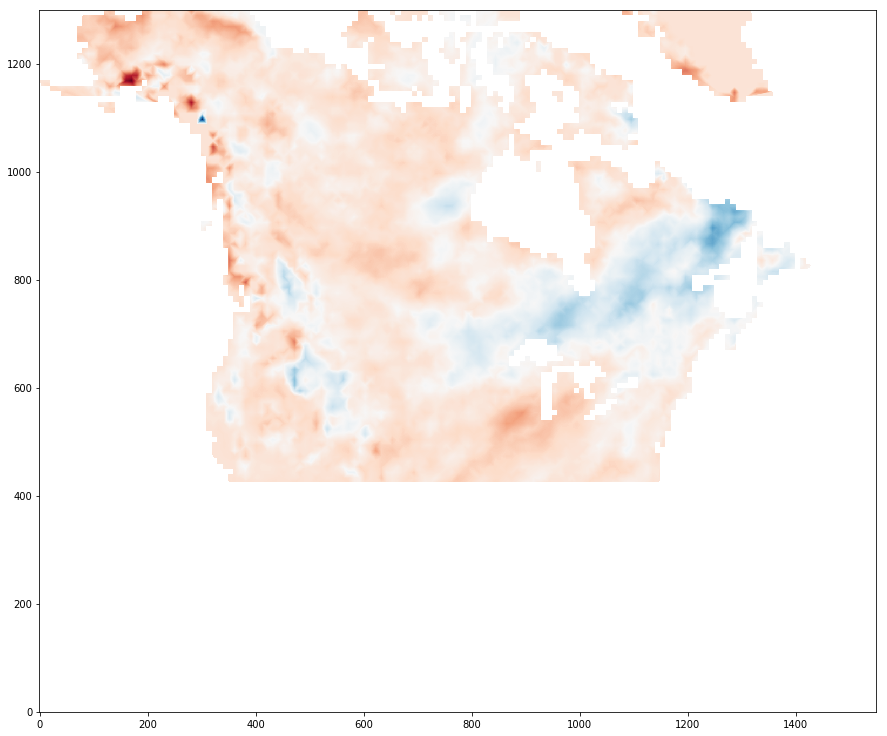

In [19]:
plt.figure(figsize=(15, 15))
plt.imshow(dv_recon_sq, cmap='RdBu', origin='lower')